In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from operator import attrgetter



/var/folders/8h/jbl1pp8n0k7_4x5d3m5tvn8c0000gn/T/ipykernel_17345/2750613303.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('/Users/steve/Documents/DSB_M2/bcg/transactions_dataset.csv', sep = ';')

In [4]:
df.columns

Index(['date_order', 'date_invoice', 'product_id', 'client_id', 'sales_net',
       'quantity', 'order_channel', 'branch_id'],
      dtype='object')

In [5]:
df.order_channel.value_counts()

order_channel
at the store                       32114196
by phone                           25465205
online                              5651866
other                                 58735
during the visit of a sales rep       29313
Name: count, dtype: int64

In [6]:
missing_values = df.isnull().sum()
print(missing_values)

date_order       0
date_invoice     1
product_id       0
client_id        0
sales_net        0
quantity         0
order_channel    0
branch_id        0
dtype: int64


In [62]:

df['date_order'] = pd.to_datetime(df['date_order'])
df['date_invoice'] = pd.to_datetime(df['date_invoice'])

df['order_invoice_delta'] = (df['date_invoice'] - df['date_order']).dt.days

print(df[['date_order', 'date_invoice', 'order_invoice_delta']].head())


  date_order date_invoice  order_invoice_delta
0 2017-09-25   2017-09-25                  0.0
1 2017-09-25   2017-09-25                  0.0
2 2017-09-25   2017-09-25                  0.0
3 2017-09-25   2017-09-25                  0.0
4 2017-09-25   2017-09-25                  0.0


In [8]:

last_purchase = df.groupby('client_id')['date_order'].max().reset_index()
last_purchase.columns = ['client_id', 'LastPurchaseDate']

# using the last available date as 'current_date'
current_date = df['date_order'].max()
last_purchase['DaysSinceLastPurchase'] = (current_date - last_purchase['LastPurchaseDate']).dt.days

# Identify customers who are at risk of churning
at_risk_customers = last_purchase[last_purchase['DaysSinceLastPurchase'] > 90]

# Recency: Days since last purchase
# Frequency: Total number of purchases
# Monetary: Total spending
df['Monetary'] = df['sales_net']
rfm = df.groupby('client_id').agg({'date_order': lambda x: (current_date - x.max()).days,
                                   'client_id': lambda x: len(x),
                                   'Monetary': lambda x: x.sum()})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [9]:
rfm

,Recency,Frequency,Monetary
client_id,,,
6,40,40,5.882233e+03
7,272,15,1.190777e+03
14,2,12762,3.103187e+06
18,10,2224,2.194882e+05
25,347,4,3.745861e+02
...,...,...,...
2274456,20,22,1.542821e+03
2274479,207,10,4.186966e+02
2274504,264,4,1.132566e+02


In [10]:
at_risk_customers.sort_values(by='DaysSinceLastPurchase', ascending=False)

,client_id,LastPurchaseDate,DaysSinceLastPurchase
111260,1486520,2017-09-25,727
148752,1983425,2017-09-25,727
70643,946412,2017-09-25,727
70965,950916,2017-09-25,727
48339,647082,2017-09-25,727
...,...,...,...
110935,1481882,2019-06-21,93
20553,274646,2019-06-21,93
41128,549688,2019-06-21,93
7358,97940,2019-06-21,93


In [11]:
last_purchase

,client_id,LastPurchaseDate,DaysSinceLastPurchase
0,6,2019-08-13,40
1,7,2018-12-24,272
2,14,2019-09-20,2
3,18,2019-09-12,10
4,25,2018-10-10,347
...,...,...,...
170584,2274456,2019-09-02,20
170585,2274479,2019-02-27,207
170586,2274504,2019-01-01,264
170587,2274508,2017-10-18,704


In [12]:
df['Month'] = df['date_order'].dt.month
seasonal_purchase_patterns = df.groupby(['client_id', 'Month']).size().reset_index(name='Count')



In [21]:
seasonal_purchase_patterns

,client_id,Month,Count
0,6,1,2
1,6,2,3
2,6,3,3
3,6,5,4
4,6,7,11
...,...,...,...
1149284,2274517,8,14
1149285,2274517,9,3
1149286,2274517,10,10
1149287,2274517,11,15


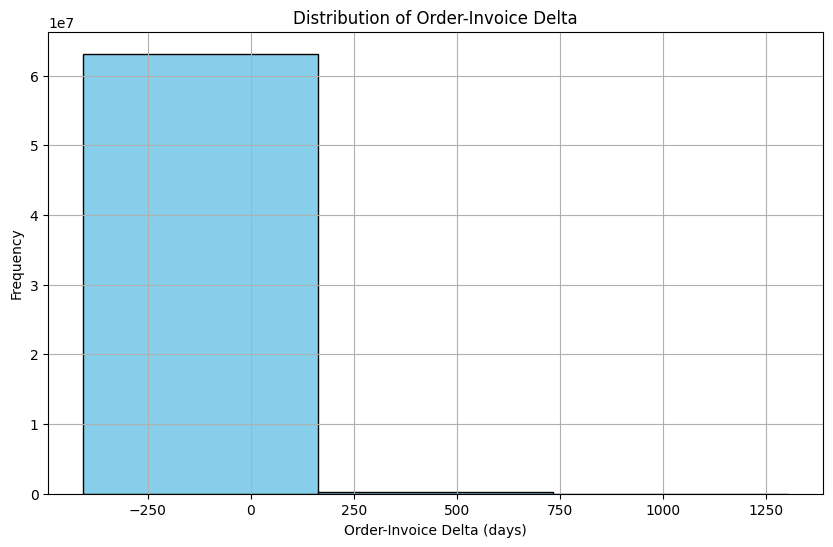

In [8]:


plt.figure(figsize=(10, 6))
plt.hist(df['order_invoice_delta'], bins=3, color='skyblue', edgecolor='black')
plt.title('Distribution of Order-Invoice Delta')
plt.xlabel('Order-Invoice Delta (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [9]:
df.order_invoice_delta.describe()

count    6.331931e+07
mean     5.053937e+00
std      1.990039e+01
min     -4.060000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.302000e+03
Name: order_invoice_delta, dtype: float64

In [10]:
df.order_invoice_delta.value_counts()

order_invoice_delta
0.0      44838996
1.0       3575762
2.0       1244054
3.0       1241320
7.0       1067508
           ...   
907.0           1
936.0           1
614.0           1
788.0           1
859.0           1
Name: count, Length: 838, dtype: int64

In [11]:
df.sales_net.describe()

count    6.331932e+07
mean     1.479416e+02
std      8.646548e+02
min     -1.738817e+06
25%      1.414653e+01
50%      4.424280e+01
75%      1.314680e+02
max      1.740456e+06
Name: sales_net, dtype: float64

In [12]:
mean_net_spend_per_channel = df.groupby('order_channel')['sales_net'].mean()
print(mean_net_spend_per_channel)


order_channel
at the store                        76.293379
by phone                           236.799459
during the visit of a sales rep    253.919790
online                             154.112002
other                              150.667432
Name: sales_net, dtype: float64


In [13]:
df[df["order_invoice_delta"]>0]

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_invoice_delta
39,2017-09-25,2017-09-26,320804,2243299,269.88108,61,by phone,1102,1.0
42,2017-09-25,2017-09-26,1988344,65987,448.38960,3,by phone,10936,1.0
55,2017-09-26,2017-09-27,1072461,1027749,146.51000,7,by phone,9162,1.0
63,2017-09-28,2017-09-29,359491,1070426,14.04840,3,by phone,2929,1.0
64,2017-09-27,2017-09-29,1201024,511577,6.80800,37,by phone,3550,2.0
...,...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682,368.0
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375,579.0
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014,461.0
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015,919.0


In [14]:
df["client_id"].value_counts()

client_id
417576     105636
1444500     91162
1773169     75883
2207247     64192
1552980     58067
            ...  
2225405         1
805795          1
1604674         1
1061872         1
235746          1
Name: count, Length: 170589, dtype: int64

In [15]:
net_spend_per_product = df.groupby('product_id')['sales_net'].sum().sort_values(ascending=False)
print(net_spend_per_product)

product_id
2681878    3.980161e+07
463156     2.488748e+07
2542409    2.337076e+07
1253061    2.271678e+07
1325810    1.956379e+07
               ...     
1343526   -6.458345e+03
495626    -7.705000e+03
2691931   -7.868705e+03
3142082   -2.064226e+04
1290329   -2.204999e+04
Name: sales_net, Length: 607418, dtype: float64


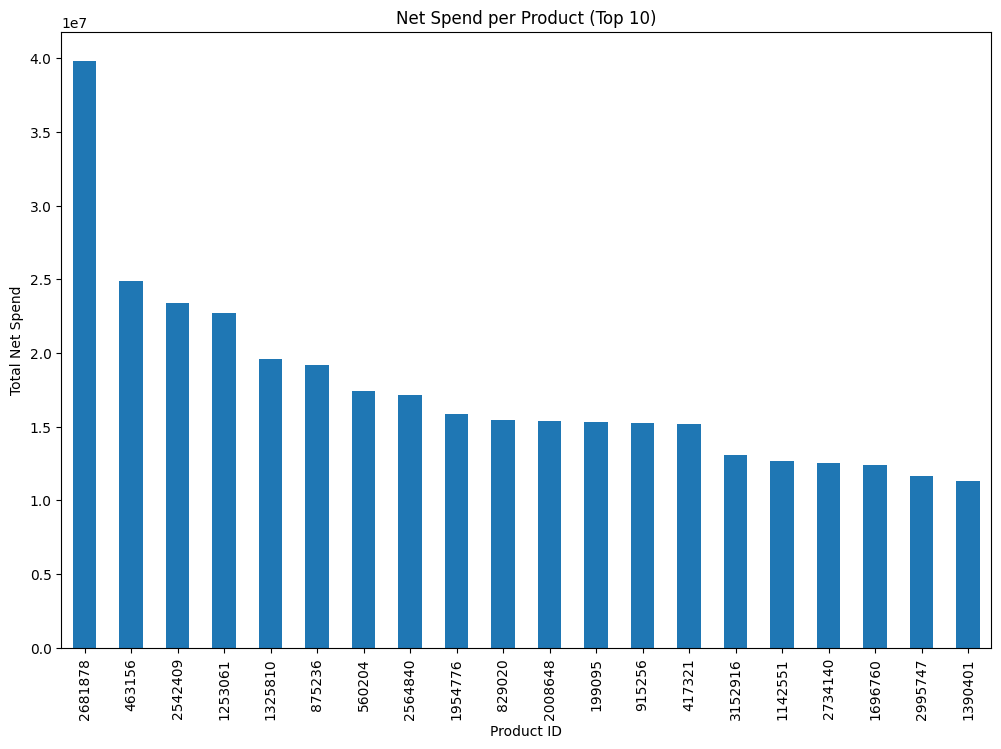

In [16]:
net_spend_per_product_top_n = net_spend_per_product.head(20)

plt.figure(figsize=(12, 8))
net_spend_per_product_top_n.plot(kind='bar')
plt.title('Net Spend per Product (Top 10)')
plt.xlabel('Product ID')
plt.ylabel('Total Net Spend')
plt.show()

In [17]:
net_spend_per_store = df.groupby('branch_id')['sales_net'].sum().sort_values(ascending=False)
print(net_spend_per_store)

branch_id
3318     1.226202e+08
4080     1.144099e+08
1894     1.140036e+08
1888     1.138640e+08
6702     1.117164e+08
             ...     
5002     1.674468e+02
2925     6.794200e+01
11024    1.136868e-13
6468     0.000000e+00
524     -2.842171e-14
Name: sales_net, Length: 582, dtype: float64


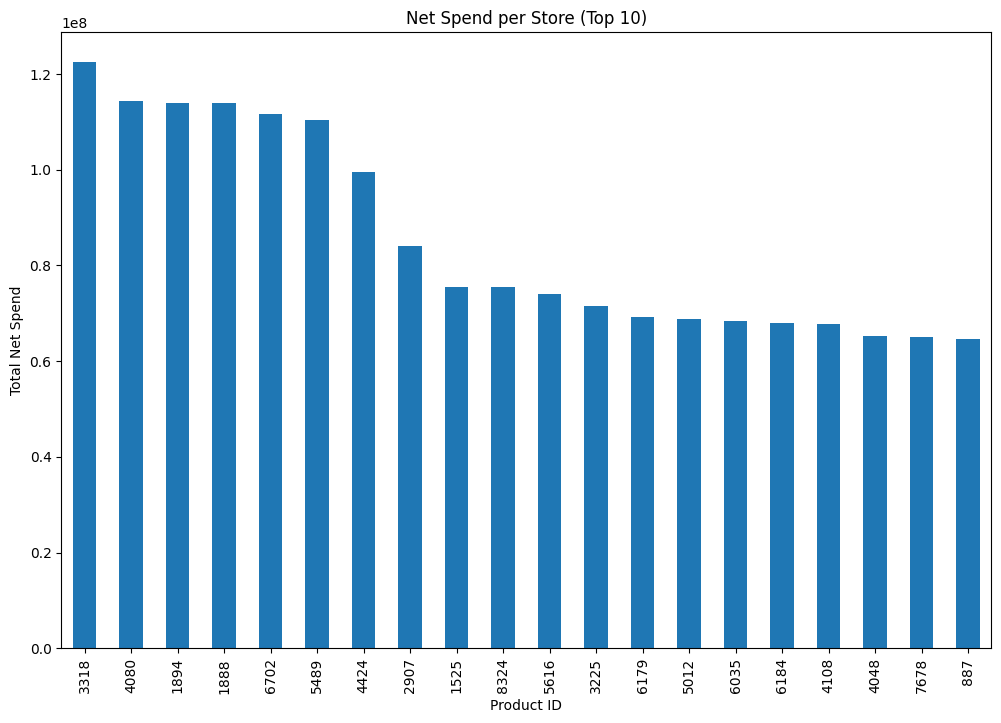

In [19]:
net_spend_per_store_top_n = net_spend_per_store.head(20)

plt.figure(figsize=(12, 8))
net_spend_per_store_top_n.plot(kind='bar')
plt.title('Net Spend per Store (Top 10)')
plt.xlabel('Product ID')
plt.ylabel('Total Net Spend')
plt.show()

In [20]:
df[df['order_invoice_delta']>0]

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_invoice_delta
39,2017-09-25,2017-09-26,320804,2243299,269.88108,61,by phone,1102,1.0
42,2017-09-25,2017-09-26,1988344,65987,448.38960,3,by phone,10936,1.0
55,2017-09-26,2017-09-27,1072461,1027749,146.51000,7,by phone,9162,1.0
63,2017-09-28,2017-09-29,359491,1070426,14.04840,3,by phone,2929,1.0
64,2017-09-27,2017-09-29,1201024,511577,6.80800,37,by phone,3550,2.0
...,...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682,368.0
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375,579.0
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014,461.0
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015,919.0


In [33]:
top_10_clients_by_sales_net = df.groupby('client_id')['sales_net'].sum().sort_values(ascending=False).head(10)
print(top_10_clients_by_sales_net)


client_id
417576     2.755879e+07
1773169    2.565979e+07
1913629    1.557873e+07
1552980    1.338733e+07
2207247    1.119328e+07
31213      1.016849e+07
2212698    9.853509e+06
324012     9.700475e+06
346256     9.453690e+06
2129476    9.004662e+06
Name: sales_net, dtype: float64


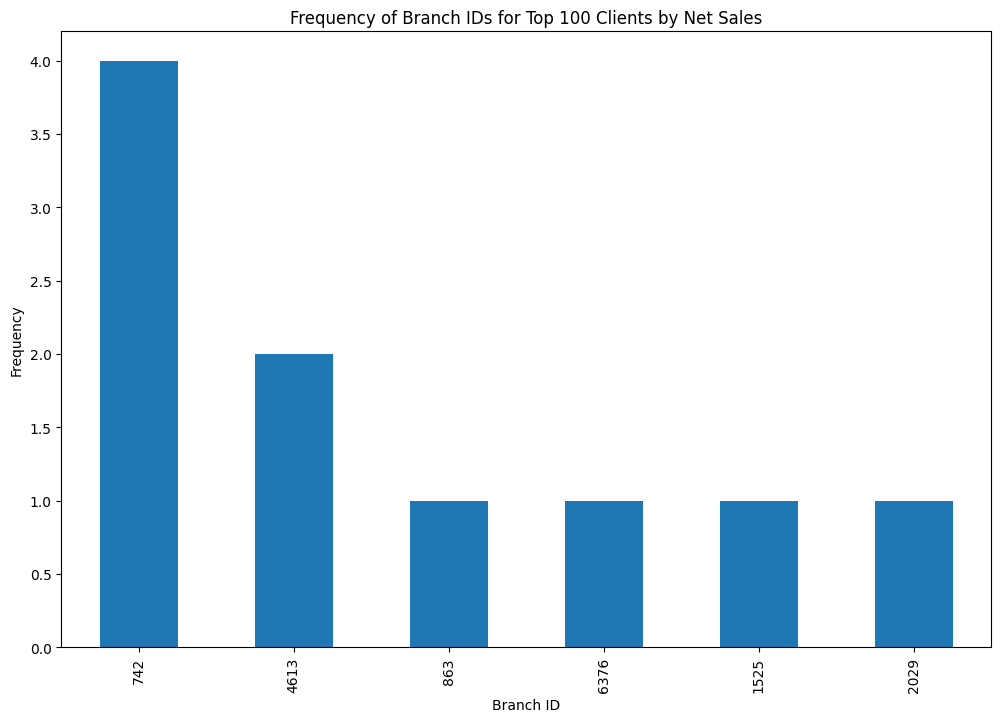

In [40]:
top_10_clients_ids = top_10_clients_by_sales_net.index
top_clients_df = df[df['client_id'].isin(top_10_clients_ids)].head(10)


plt.figure(figsize=(12, 8))
top_clients_df['branch_id'].value_counts().plot(kind='bar')
plt.title('Frequency of Branch IDs for Top 100 Clients by Net Sales')
plt.xlabel('Branch ID')
plt.ylabel('Frequency')
plt.show()

In [14]:
grouped_orders = df.groupby(['client_id', 'product_id']).agg({'date_order': ['count', 'min', 'max'], 'quantity': 'sum'}).reset_index()
grouped_orders.columns = ['client_id', 'product_id', 'total_orders', 'first_order_date', 'last_order_date', 'total_quantity']


In [15]:
repeated_orders = grouped_orders[grouped_orders['total_orders'] > 1]

repeated_orders['average_order_frequency'] = (repeated_orders['last_order_date'] - repeated_orders['first_order_date']) / (repeated_orders['total_orders'] - 1)


/var/folders/8h/jbl1pp8n0k7_4x5d3m5tvn8c0000gn/T/ipykernel_3675/1926756912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repeated_orders['average_order_frequency'] = (repeated_orders['last_order_date'] - repeated_orders['first_order_date']) / (repeated_orders['total_orders'] - 1)


In [31]:
repeated_orders.sort_values(by = 'total_orders', ascending=False).head(40)

,client_id,product_id,total_orders,first_order_date,last_order_date,total_quantity,average_order_frequency
11723714,1015601,3100261,7763,2017-09-25,2019-09-20,49601,0 days 02:14:30.085029631
17926964,1539945,1869701,3952,2017-09-25,2019-09-20,27880,0 days 04:24:14.214123006
9554757,819976,788817,3427,2017-10-04,2019-08-30,175177,0 days 04:52:07.145359019
375867,31213,3000784,3404,2017-09-25,2019-09-20,12064,0 days 05:06:47.287687334
4904542,417576,3000784,2772,2017-09-25,2019-09-20,10216,0 days 06:16:45.557560447
4894008,417576,1895362,2708,2017-09-29,2019-09-20,61052,0 days 06:23:32.338381972
9834712,845385,114938,2583,2017-09-25,2019-09-20,7839,0 days 06:44:20.263361735
23791942,2032346,114938,1911,2017-09-25,2019-09-20,5811,0 days 09:06:35.811518324
12149358,1049145,2811481,1871,2017-10-30,2019-09-19,180075,0 days 08:50:34.010695187
9109135,782240,3000784,1669,2017-09-26,2019-09-18,6381,0 days 10:23:18.561151079


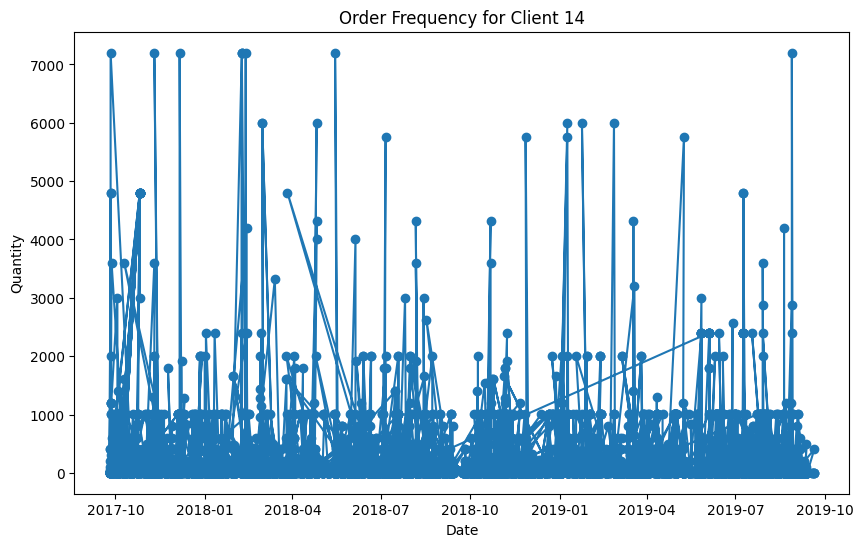

In [25]:
# Example: Filtering clients who order roughly every 30 days (with some tolerance)
subscription_like = repeated_orders[(repeated_orders['average_order_frequency'] > pd.Timedelta(days=25)) & (repeated_orders['average_order_frequency'] < pd.Timedelta(days=35))]

import matplotlib.pyplot as plt


client_id = subscription_like.iloc[50]['client_id'] # Plotting order frequency for a specific client
client_orders = df[df['client_id'] == client_id]

plt.figure(figsize=(10, 6))
plt.plot(client_orders['date_order'], client_orders['quantity'], marker='o')
plt.title(f'Order Frequency for Client {client_id}')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()


In [30]:
volume_categories = df.groupby('client_id')['quantity'].sum().reset_index(name='TotalQuantity')
volume_categories.sort_values(by='TotalQuantity', ascending=False).head(35)

,client_id,TotalQuantity
132725,1773169,47722799
64498,864026,29856285
18146,243127,28240356
116216,1552980,13352433
103835,1386568,12585785
10143,135325,12356005
14207,188926,11854554
102747,1372496,11395761
167380,2232451,11003896
31226,417576,10908882


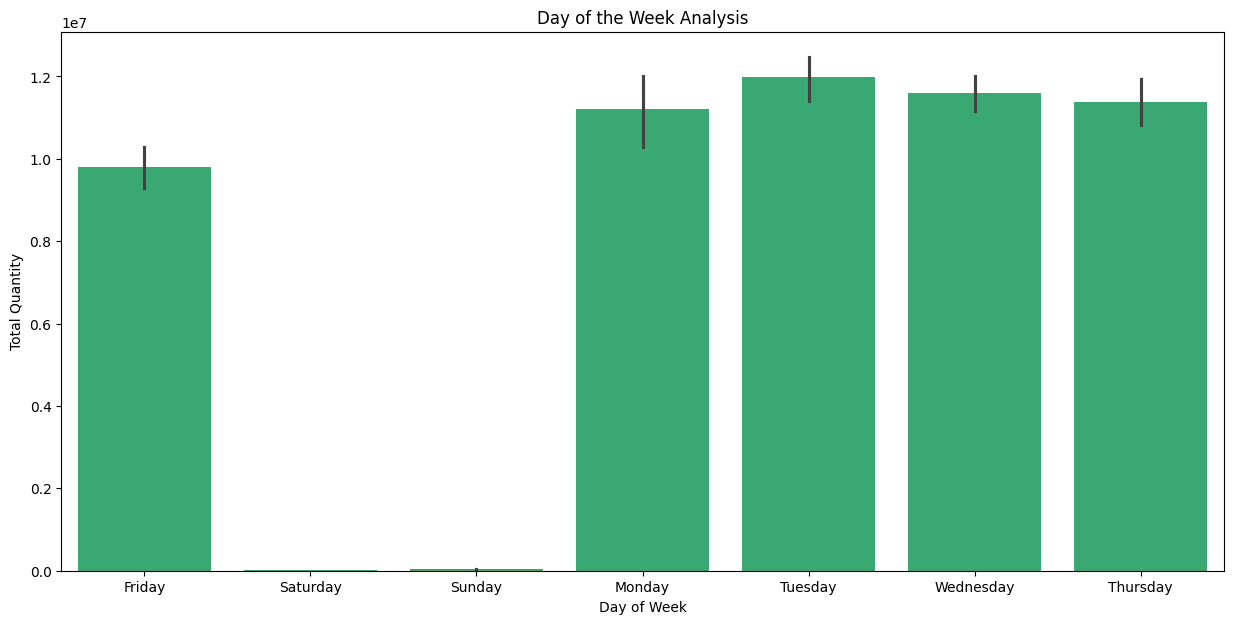

In [73]:
day_total_quantity = df.groupby('date_order')['quantity'].sum().reset_index(name='TotalQuantity')
day_total_quantity['date_order'] = pd.to_datetime(day_total_quantity['date_order'])
day_total_quantity.set_index('date_order', inplace=True)

day_total_quantity['day_of_week'] = day_total_quantity.index.day_name()
plt.figure(figsize=(15, 7))
sns.barplot(x='day_of_week', y='TotalQuantity', data=day_total_quantity, color = '#28BA74')
plt.title('Day of the Week Analysis')
plt.xlabel('Day of Week')
plt.ylabel('Total Quantity')
plt.show()

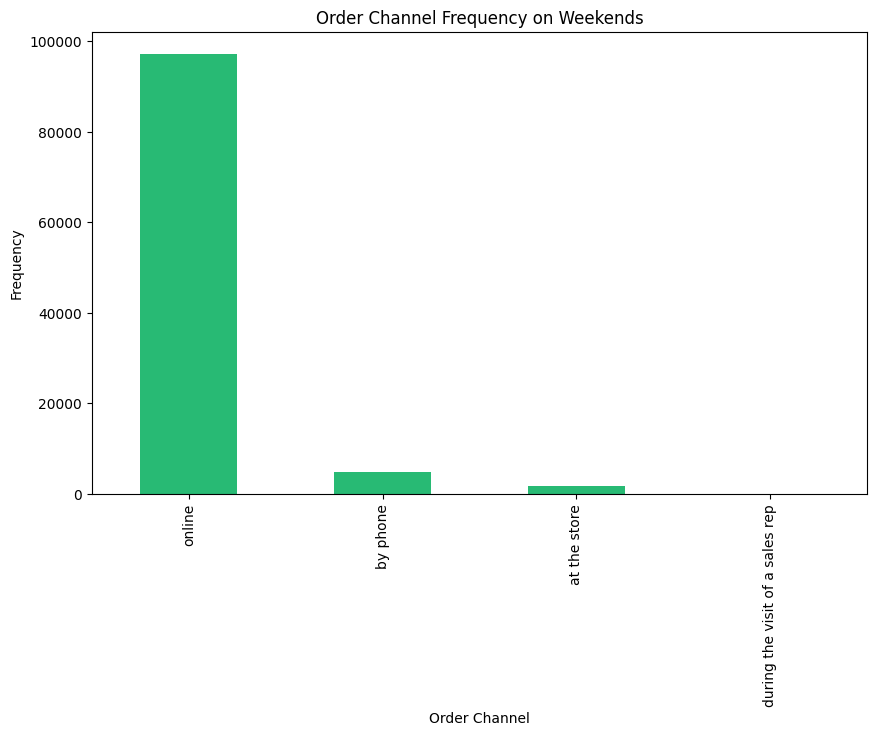

In [75]:
df['day_of_week'] = df['date_order'].dt.day_name()
weekend_orders = df[df['day_of_week'].isin(['Saturday', 'Sunday'])]
weekend_order_channel_frequency = weekend_orders['order_channel'].value_counts()

plt.figure(figsize=(10, 6))
weekend_order_channel_frequency.plot(kind='bar', color = '#28BA74')
plt.title('Order Channel Frequency on Weekends')
plt.xlabel('Order Channel')
plt.ylabel('Frequency')
plt.show()


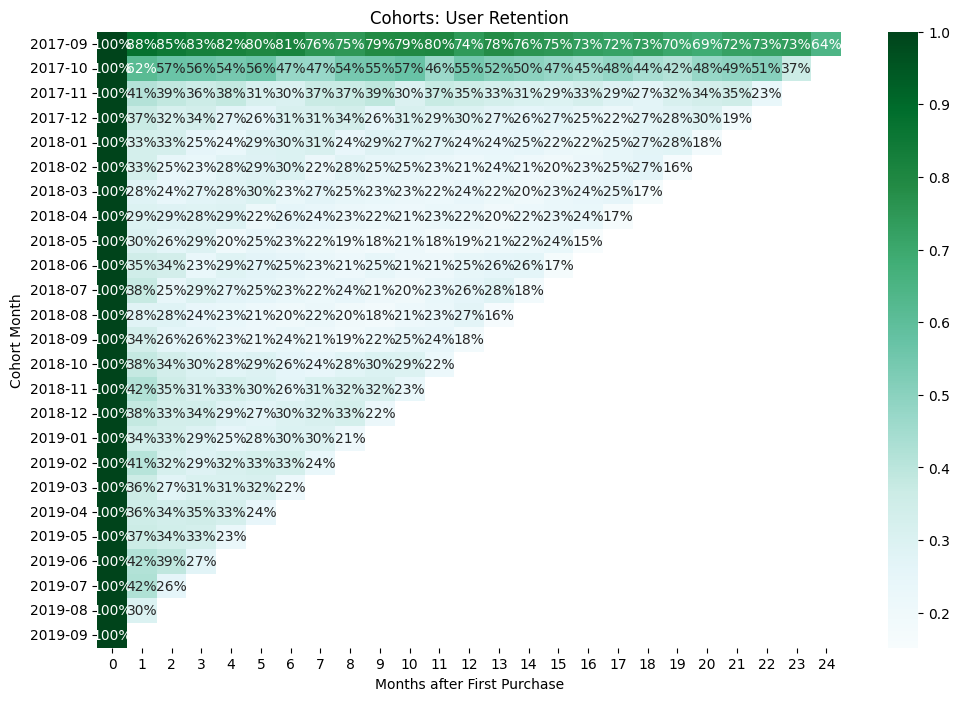

In [79]:
df['date_order'] = pd.to_datetime(df['date_order'])

# Create a Cohort Month and Order Month column
df['OrderMonth'] = df['date_order'].dt.to_period('M')
df['CohortMonth'] = df.groupby('client_id')['date_order'].transform('min').dt.to_period('M')

# Group by CohortMonth and OrderMonth and count the unique number of customers
cohort_data = df.groupby(['CohortMonth', 'OrderMonth']).agg(n_customers=('client_id', 'nunique')).reset_index()

# Create a Cohort Index representing the number of periods since the first purchase
cohort_data['CohortIndex'] = (cohort_data.OrderMonth - cohort_data.CohortMonth).apply(attrgetter('n'))

# Pivot the data to create a cohort analysis table
cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='n_customers')

# Calculate retention rates
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Plotting the retention rates
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='BuGn')
plt.title('Cohorts: User Retention')
plt.ylabel('Cohort Month')
plt.xlabel('Months after First Purchase')
plt.show()


# Modelling

In [15]:
from BCG_Data_Strategy.src.dataloader import final_preprocessing
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:


data_path = Path('/Users/steve/Documents/DSB_M2/bcg/transactions_dataset.csv')
drop_time = 180
churn_time = 180
recent_to = 180
day_diff_to = 4
total_days_to = 3

train_df = final_preprocessing(data_path, drop_time, churn_time, recent_to, day_diff_to, total_days_to)


In [5]:
test_drop_time = 0

test_df = final_preprocessing(data_path, test_drop_time, churn_time, recent_to, day_diff_to, total_days_to)


In [7]:
X_train = train_df.drop('churn', axis=1)
y_train = train_df['churn']

X_test = test_df.drop('churn', axis=1)
y_test = test_df['churn']

## Baseline model

In [8]:
model = xgb.XGBClassifier(objective='binary:logistic', seed=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.678748006779457


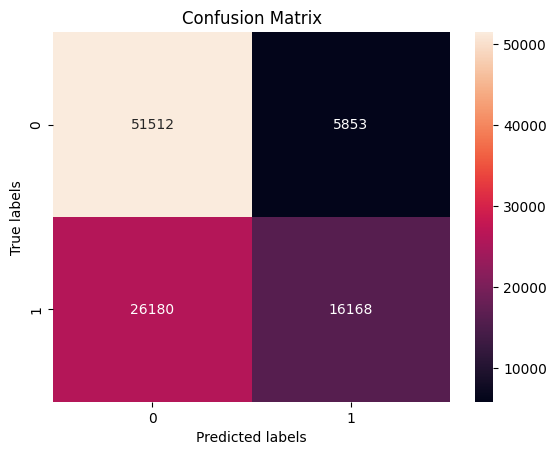

In [9]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

AUC: 0.7843787778223641


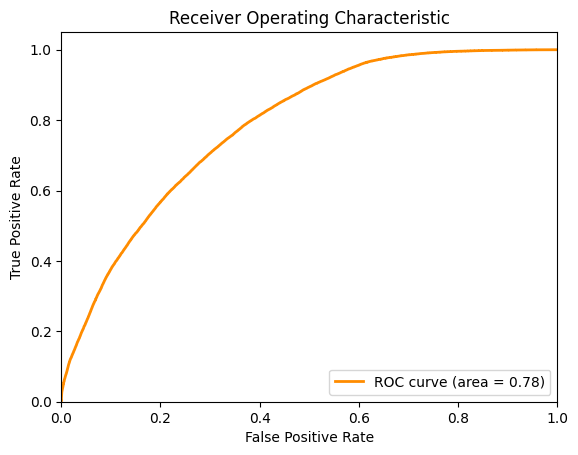

In [16]:
y_pred_proba = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Random search 

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=42)

random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_grid, 
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, 
                                   random_state=42)

random_search.fit(X_train, y_train)

best_estimator = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)

predictions = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy with Best Parameters: {accuracy}")


Best Parameters: {'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Model Accuracy with Best Parameters: 0.6882653214726264


In [18]:
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.6882653214726264


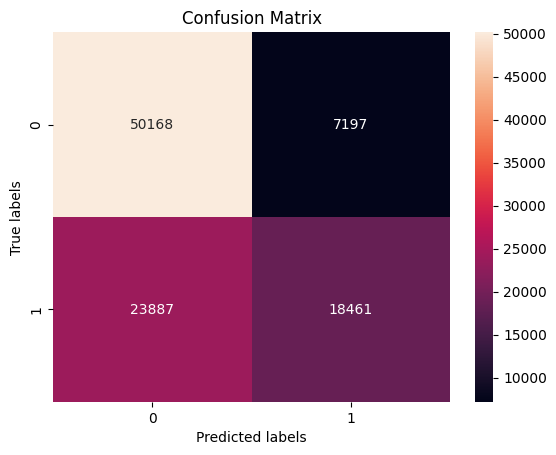

In [19]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

AUC: 0.7877676178808598


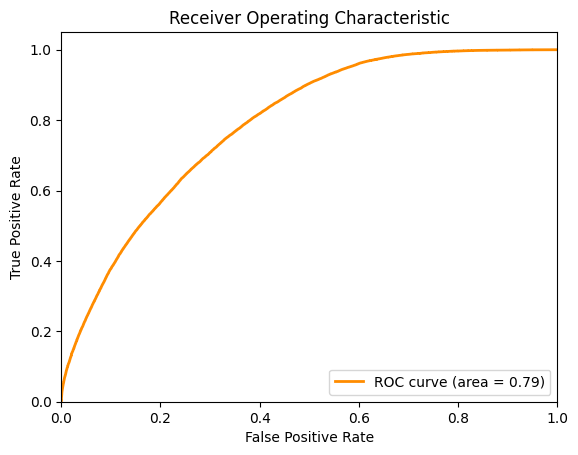

In [20]:
y_pred_proba = best_estimator.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Addition of more data

In [21]:
relationship_df = pd.read_excel('/Users/steve/Documents/DSB_M2/bcg/sales_client_relationship_dataset.xlsx')

relationship_encoded = pd.get_dummies(relationship_df, columns=['quali_relation'])

train_df1 = train_df.merge(relationship_encoded, on='client_id', how='left')
test_df1 = test_df.merge(relationship_encoded, on='client_id', how='left')


Model Accuracy: 0.6750674435630258
AUC: 0.7857911348216033


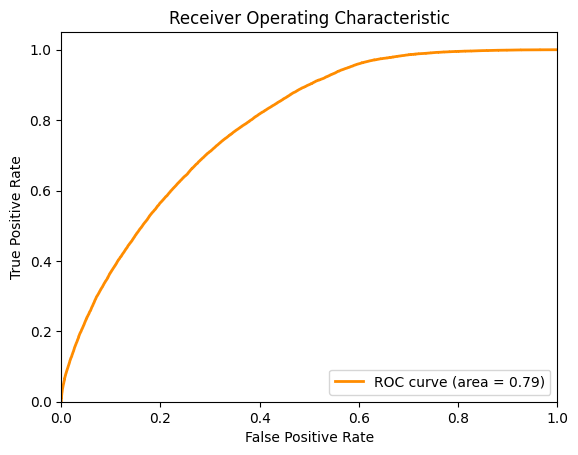

In [22]:
X_train = train_df1.drop('churn', axis=1)
y_train = train_df1['churn']

X_test = test_df1.drop('churn', axis=1)
y_test = test_df1['churn']

## Baseline model with more data
model = xgb.XGBClassifier(objective='binary:logistic', seed=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")


y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Grid Search

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=42)

grid_search = GridSearchCV(xgb_classifier, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

predictions = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy with Best Parameters: {accuracy}")


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 200}
Model Accuracy with Best Parameters: 0.6900003008634782


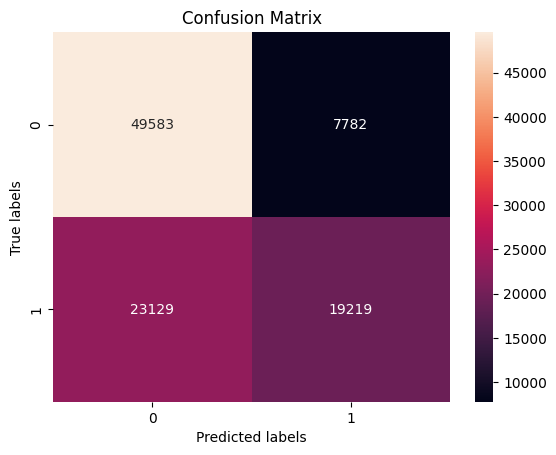

In [25]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

AUC: 0.7861383784406544


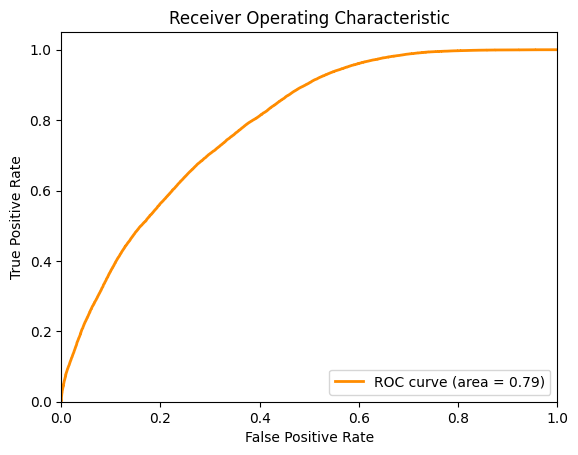

In [26]:
y_pred_proba = best_estimator.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()